# Intro to Xarray: 4D Earth Observation made easy

Earth observation is the science - and art - of... observing the Earth!

We use many tools and sensors, but satellite images are easy to work with and very popular.

They're easy to work with because images, and timeseries of images, are arrays or grids.

![](http://www.teaching.com.au/resources/static/main/image/ey998.jpg)

In Python, we can use Numpy for efficient operations on gridded data that fits in memory.  
(and Dask expands that to 'fits on disk' or 'fits on cluster', with streaming computation and task-graph optimisation)

But this is a talk about Xarray!  Xarray adds many useful features:

- Coordinate-aware arrays - with automatic alignment, indexing by coordinates, etc
- Many more useful operations (grouping, reductions, plotting, etc)
- Powerful IO and distributed computing tools
- Integrates beautifully with Pandas

If you're using Numpy + Pandas, you should probably use Xarray instead.

### Now for a non-live demo

(You can run this notebook at home, but I'm not betting my talk on the wifi)

We're going to load and play around with a public-access image file from our local national supercomputing facility...

In [1]:
import xarray as xr
%matplotlib inline

C:\Users\Zac\Anaconda3\envs\remote-sensing\lib\site-packages\xarray\core\formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


You can open a dataset from a filename, use a glob pattern to open and combine multiple files, or even load data from a URL via several protocols.

This is all automatic, and very efficient - it loads the coordinates immediately, but doesn't load data until you use it (usually; and sometimes not even then)



In [2]:
ds = xr.open_dataset('http://dapds00.nci.org.au/thredds/dodsC/ub8/au/RegionTimeSeries/nbar_pq_ndvi.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 12, x: 1119, y: 1772)
Coordinates:
  * y        (y) float32 -3.94951e+06 -3.94954e+06 -3.94956e+06 -3.94959e+06 ...
  * time     (time) datetime64[ns] 2002-12-08T23:38:32.467200 ...
  * x        (x) float32 1.51136e+06 1.51139e+06 1.51141e+06 1.51144e+06 ...
Data variables:
    blue     (time, y, x) float32 ...
    green    (time, y, x) float32 ...
    red      (time, y, x) float32 ...
    nir      (time, y, x) float32 ...
    swir1    (time, y, x) float32 ...
    swir2    (time, y, x) float32 ...
Attributes:
    _NCProperties:  version=1|netcdflibversion=4.4.1.1|hdf5libversion=1.8.17
    crs:            EPSG:3577
    history:        Extracted from the GA Datacube by Zac Hatfield-Dodds with...

In [3]:
ds = ds.isel(x=slice(None, None, 5), y=slice(None, None, 5))
ds.load()
ds.nbytes

22904172

Here's a taste of Xarray - we take the mean along the time dimension, then turn our dataset into an array with a wavelength dimension, and plot it.  In one line.  (~sixty lines of error-prone Numpy + Matplotlib)

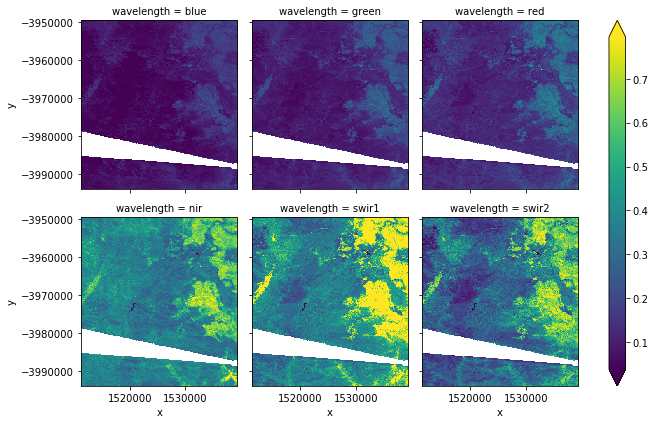

In [8]:
ds.mean(dim='time').to_array('wavelength')\
.plot.imshow(col='wavelength', col_wrap=3, robust=True)

### Science time!

- Different things are different colours
- That means they reflect different proportions of sunlight across the visible and non-visible spectrum

![](http://www.seos-project.eu/modules/classification/images/spectral_signatures_landsat.jpg)

- I promise this will be useful on the next slide

NDVI is a common index for vegetation - values closer to 1 are healthier plants; values closer to zero are soil, and negative is usually open water.

This is old-school image analysis, where instead recognising multi-pixel objects we recognise sub-pixel properties.

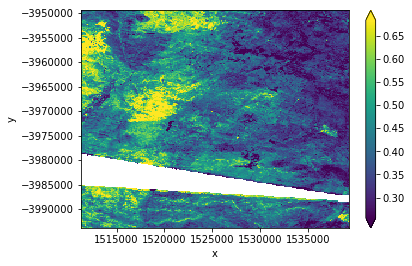

In [9]:
ndvi = (ds.nir - ds.red) / (ds.nir + ds.red)
ndvi.mean(dim='time').plot.imshow(robust=True)

We can also plot each individual timestep, but notice that missing data becomes a much larger problem.  
The angular gaps lie between satellite tracks; the random patches are clouds blocking our view.

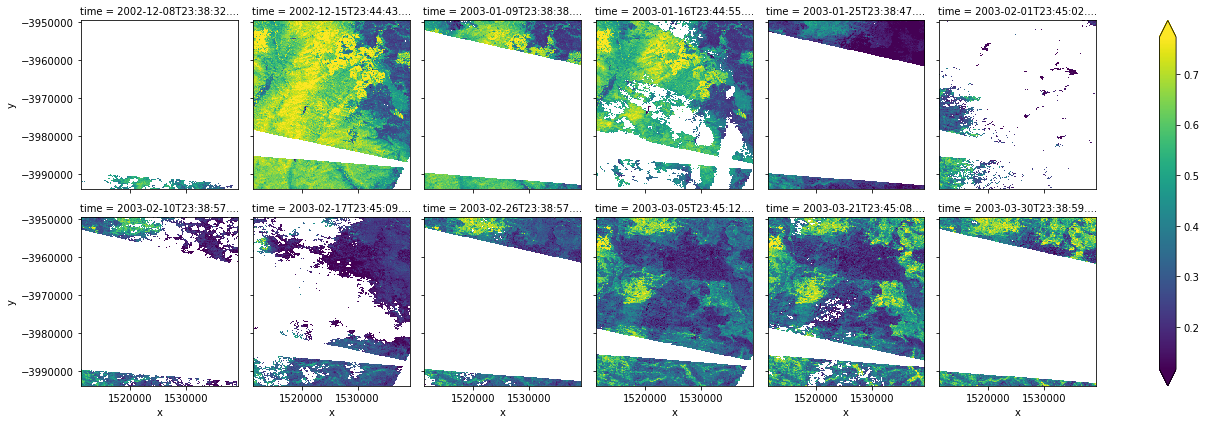

In [10]:
ndvi.plot.imshow(col='time', col_wrap=6, robust=True)

Why do the earlier images look so different to the later ones?

If we compare all images taken in January to March, we can see some patterns:

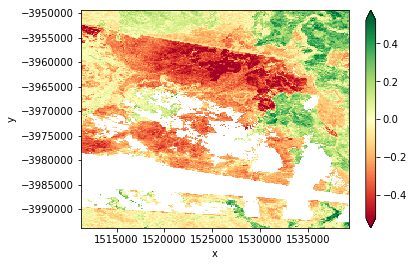

In [11]:
jan = ndvi.sel(time='2003-01').mean(dim='time')
march = ndvi.sel(time='2003-03').mean(dim='time')
(march - jan).plot.imshow(robust=True, cmap='RdYlGn')

- Red areas were burned by the bushfires and lost vegetation
- Green areas were not burned, and were greener with end-of-summer-rain
- Missing data has an obvious effect on the composite image